<a href="https://colab.research.google.com/github/akshaya-nagarajan/AdvancedDeepLearning/blob/master/Assignment_2/LinearRegression_LogisticRegression_GradientTape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression on artificaially generated dataset

## Import required Libraries

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.datasets import mnist
from __future__ import absolute_import, division, print_function

## Set Parameters

In [ ]:
input_dim = 2
output_dim = 1
learning_rate = 0.01

## Weight and Bias

In [ ]:
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(tf.zeros(shape=(output_dim,)))

## Predict Function

In [ ]:
def compute_predictions(features):
  return tf.matmul(features, w) + b

## Loss Function

In [ ]:
def compute_loss(labels, predictions):
  return tf.reduce_mean(tf.square(labels - predictions))

## Method for Training - Gradient Tape

In [ ]:
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

## Generate Data for performing linear classification

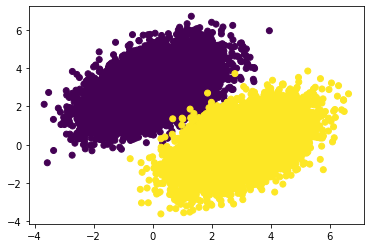

In [ ]:
num_samples = 10000
negative_samples = np.random.multivariate_normal(mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
positive_samples = np.random.multivariate_normal(mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'), np.ones((num_samples, 1), dtype='float32')))
plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])

## Get Labels and Features

In [ ]:
indices = np.random.permutation(len(features))
features = features[indices]
labels = labels[indices]

## Train the model on the generated Dataset

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

for epoch in range(10):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 0.0812
Epoch 1: last batch loss = 0.0617
Epoch 2: last batch loss = 0.0327
Epoch 3: last batch loss = 0.0333
Epoch 4: last batch loss = 0.0253
Epoch 5: last batch loss = 0.0268
Epoch 6: last batch loss = 0.0239
Epoch 7: last batch loss = 0.0137
Epoch 8: last batch loss = 0.0258
Epoch 9: last batch loss = 0.0262


## Compute Predictions and Plot

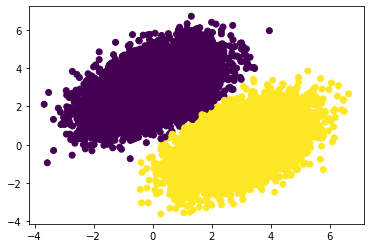

In [ ]:
predictions = compute_predictions(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0] > 0.5)

# Logistic Regression on MNIST Dataset

## Set Parameters

In [ ]:
num_classes = 10
num_features = 784
learning_rate = 0.01
training_steps = 1000
batch_size = 256
display_step = 50

## Load MNIST Dataset, Split into train and test

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Convert to float, Flatten images to 1-D vector of 784 features (28*28) and Normalize the data

In [ ]:
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

## Shuffling and Batching the Data

In [ ]:
train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data=train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

## Weights and Bias

In [ ]:
W = tf.Variable(tf.ones([num_features, num_classes]), name="weight")
b = tf.Variable(tf.zeros([num_classes]), name="bias")

## Defining functions for logistic regression and cost

In [ ]:
def logistic_regression(x):
    return tf.nn.softmax(tf.matmul(x, W) + b)

def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

## Optimizers and accuracy metrics

In [ ]:
def accuracy(y_pred, y_true):
  correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
  return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.optimizers.SGD(learning_rate)

## Wrap computation inside a GradientTape for automatic differentiation. Compute gradients and Update W and b following gradients.

In [ ]:
def run_optimization(x, y):
  with tf.GradientTape() as g:
        pred = logistic_regression(x)
        loss = cross_entropy(pred, y)
  gradients = g.gradient(loss, [W, b])
  optimizer.apply_gradients(zip(gradients, [W, b]))

## Training the model

In [ ]:
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    run_optimization(batch_x, batch_y)
    if step % display_step == 0:
        pred = logistic_regression(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 50, loss: 433.910736, accuracy: 0.777344
step: 100, loss: 105.122772, accuracy: 0.894531
step: 150, loss: 179.242111, accuracy: 0.859375
step: 200, loss: 128.324173, accuracy: 0.863281
step: 250, loss: 66.898018, accuracy: 0.910156
step: 300, loss: 47.693451, accuracy: 0.945312
step: 350, loss: 119.721069, accuracy: 0.867188
step: 400, loss: 83.206490, accuracy: 0.917969
step: 450, loss: 40.093369, accuracy: 0.957031
step: 500, loss: 214.239548, accuracy: 0.812500
step: 550, loss: 62.796047, accuracy: 0.933594
step: 600, loss: 106.374222, accuracy: 0.878906
step: 650, loss: 69.215897, accuracy: 0.894531
step: 700, loss: 55.689941, accuracy: 0.945312
step: 750, loss: 81.803696, accuracy: 0.914062
step: 800, loss: 85.138191, accuracy: 0.914062
step: 850, loss: 64.923752, accuracy: 0.949219
step: 900, loss: 87.696701, accuracy: 0.902344
step: 950, loss: 48.898518, accuracy: 0.941406
step: 1000, loss: 81.767578, accuracy: 0.910156


## Testing the model

In [ ]:
pred = logistic_regression(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.886100
